# Homework 4

## Mysql-Python Connection

In [6]:
import mysql.connector
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import csv

%matplotlib inline

In [7]:
db_connection = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="**.", # change password
  auth_plugin='mysql_native_password'
)
print(db_connection)

In [8]:
# creating database_cursor to perform SQL operation to run queries
db_cursor = db_connection.cursor(buffered=True)

# executing cursor with execute method and pass SQL query
db_cursor.execute("CREATE DATABASE ps_ecommerce")

# get list of all databases
db_cursor.execute("SHOW DATABASES")

# print all databases
for db in db_cursor:
    print(db)
    
db_cursor.execute("USE ps_ecommerce")

('comp306',)
('information_schema',)
('mysql',)
('performance_schema',)
('ps_ecommerce',)
('sys',)
('world',)


## Load Data to Mysql Tables

In [9]:
def populate_table(db_connection, db_cursor, insert_query, file_path):
    
    with open(file_path, mode='r') as csv_data:
        reader = csv.reader(csv_data, delimiter=';')
        csv_data_list = list(reader)
        for row in csv_data_list[1:]:
            row = tuple(map(lambda x: None if x == "" else x, row[0].split(',')))
            db_cursor.execute(insert_query, row)
        
    db_connection.commit()

In [10]:
# create CUSTOMERS table
db_cursor.execute("""CREATE TABLE CUSTOMERS (customer_id VARCHAR(50) NOT NULL, 
                                          customer_unique_id VARCHAR(50) NOT NULL, 
                                          customer_zip_code_prefix VARCHAR(50), 
                                          customer_city VARCHAR(50), 
                                          customer_state VARCHAR(50))""")

insert_customers = (
    "INSERT INTO CUSTOMERS(customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state) "
    "VALUES (%s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_customers, "/Users/efe/Downloads/data/customers.csv")

In [11]:
# create ORDER_PAYMENTS table
db_cursor.execute("""CREATE TABLE ORDER_PAYMENTS (order_id VARCHAR(50) NOT NULL, 
                                          payment_sequential INTEGER, 
                                          payment_type VARCHAR(50), 
                                          payment_installments INTEGER, 
                                          payment_value FLOAT)""")

insert_orderpayments = (
    "INSERT INTO ORDER_PAYMENTS(order_id, payment_sequential, payment_type, payment_installments, payment_value) "
    "VALUES (%s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_orderpayments, "/Users/efe/Downloads/data/order_payments.csv")

In [12]:
# create ORDER_ITEMS table
db_cursor.execute("""CREATE TABLE ORDER_ITEMS (order_id VARCHAR(50) NOT NULL, 
                                          order_item_id INTEGER, 
                                          product_id VARCHAR(50), 
                                          seller_id VARCHAR(50), 
                                          shipping_limit_date DATETIME,
                                          price FLOAT,
                                          freight_value FLOAT)""")

insert_orderitems = (
    "INSERT INTO ORDER_ITEMS(order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value) "
    "VALUES (%s, %s, %s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_orderitems, "/Users/efe/Downloads/data/order_items.csv")

In [13]:
# create ORDERS table
db_cursor.execute("""CREATE TABLE ORDERS (order_id VARCHAR(50) NOT NULL, 
                                          customer_id VARCHAR(50) NOT NULL, 
                                          order_status VARCHAR(50), 
                                          order_purchase_timestamp DATETIME, 
                                          order_approved_at DATETIME,
                                          order_delivered_carrier_date DATETIME,
                                          order_delivered_customer_date DATETIME,
                                          order_estimated_delivery_date DATETIME)""")

insert_orders = (
    "INSERT INTO ORDERS(order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date) "
    "VALUES (%s, %s, %s, %s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_orders, "/Users/efe/Downloads/data/orders.csv")

## Question 1 (10 pts)

In [14]:
# Find the average number of weeks between products' actual delivery dates and estimated delivery dates. 
# Use order_delivered_customer_date column as actual delivery dates and 
# order_estimated_delivery_date column as estimated delivery dates.

# HINT: There is a function in MySQL that makes it easy to compute the difference between two timestamps.
# We recommend that you search for it online and use it in your answer.

In [15]:
# Solve Question 1 below
db_cursor.execute("""
                    SELECT AVG(ABS(TIMESTAMPDIFF(week, order_estimated_delivery_date, order_delivered_customer_date)))
                    FROM ps_ecommerce.ORDERS 
                    where order_status='delivered'
                     """)

week = db_cursor.fetchone()

for x in week:
    print(x)


1.3385


## Question 2 (15 pts)

In [16]:
# Consider the ORDER_COSTS table below. Using this table and the CUSTOMERS table, find the following:
# In which states do customers spend, on average, more than 164 on their orders? 
# Fetch those states and average order costs in those states. Results should be ordered from lowest cost to highest.

In [17]:
order_costs_query = """
                    CREATE TABLE ORDER_COSTS AS (
                        SELECT ORDERS.order_id, SUM(price) AS cost, ORDERS.customer_id as cid
                        FROM ORDER_ITEMS 
                             JOIN ORDERS
                             ON ORDER_ITEMS.order_id=ORDERS.order_id
                        GROUP BY order_id, ORDERS.customer_id)
                    """

db_cursor.execute(order_costs_query)

In [18]:
# Solve Question 2 below
db_cursor.execute("""
                    SELECT customer_state, avg(cost) AS average
                    FROM ORDER_COSTS JOIN CUSTOMERS
                         ON CUSTOMERS.customer_id = ORDER_COSTS.cid
                    GROUP BY (customer_state)
                    HAVING 164 < (average)
                    ORDER BY average
                    """)

result = db_cursor.fetchall()
for x in result:
    print(x)



('PE', 165.95715586927687)
('RN', 168.72618171229507)
('MS', 173.50979253761005)
('TO', 179.9429249493581)
('PA', 182.85564198849806)
('MT', 184.82068734097837)
('AL', 202.31006200565315)
('RO', 217.85388387291178)
('PB', 222.1680950891404)
('AC', 224.56719970703125)
('RR', 279.38705960442036)


## Question 3 (15 pts)

In [19]:
# Implement the following function get_month. It takes as input a month as an integer.
# It needs to compute: In the given month, how many payments were made with each different payment type?
# e.g.: Credit card -> 5000 payments, debit card -> 100 payments, voucher -> 300 payments, ...

# HINT: One of the MySQL functions we covered in the PS makes it easy to work with months.

In [20]:
# Solve Question 3 below

def get_month(month):
    
    query = "Select payment_type as type, count(*) as adet from ORDERS natural join ORDER_PAYMENTS where MONTH(order_purchase_timestamp)= " + month + " GROUP BY payment_type Order By adet"
    db_cursor.execute(query)
    items = db_cursor.fetchall()
    
    return items

In [21]:
# Here is a sample function call for get_month:
print(get_month("2"))

[('debit_card', 82), ('voucher', 424), ('boleto', 1723), ('credit_card', 6609)]


## Question 4 (10 pts)

In [22]:
# Consider the PRODUCTS table below and the ORDER_ITEMS table from earlier. 
# For each product category other than {"moveis_decoracao", "beleza_saude"}, find the minimum price that was paid for
# an item from that category. Limit the result to retrieve only 6 rows.

# The result should be like: category1 -> minprice1, category2 -> minprice2, ...

In [23]:
db_cursor.execute("""CREATE TABLE PRODUCTS (product_id VARCHAR(50) NOT NULL, 
                                            product_category_name VARCHAR(50), 
                                            product_name_lenght INTEGER, 
                                            product_description_lenght INTEGER, 
                                            product_photos_qty INTEGER,
                                            product_weight_g INTEGER,
                                            product_length_cm INTEGER,
                                            product_height_cm INTEGER,
                                            product_width_cm INTEGER)""")

insert_products = (
    "INSERT INTO PRODUCTS(product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm,  product_height_cm, product_width_cm) "
    "VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_products, "/Users/efe/Downloads/data/products.csv")

In [24]:
# Solve Question 4 below

db_cursor.execute("""
                    SELECT min(price), product_category_name 
                    from ORDER_ITEMS natural join PRODUCTS 
                    Group by product_category_name 
                    Having not (product_category_name='moveis_decoracao' or product_category_name='beleza_saude') 
                    limit 6
                    """)

result = db_cursor.fetchall()
for x in result:
    print(x)

(5.49, 'esporte_lazer')
(4.4, 'utilidades_domesticas')
(6.99, 'cama_mesa_banho')
(3.9, 'informatica_acessorios')
(8.99, 'relogios_presentes')
(4.99, 'brinquedos')


## Question 5 (10 pts)

In [25]:
# Draw a pie chart using the data from the previous question.
# Labels of your pie chart should be the product categories.
# Contents of your pie chart (i.e., sizes of the pie slices) should be determined by the min prices.

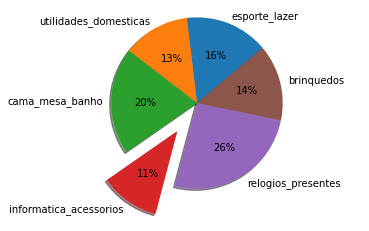

In [26]:
# Solve Question 5 below

price, category = map(list, zip(*result))
#print(month, order)

exp = (0, 0, 0, 0.4, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(price, explode=exp, labels=category, autopct='%1.0f%%', shadow=True, startangle=40)
ax1.axis('equal') 
plt.show()

## Question 6 (15 pts)

In [27]:
# Let us define "large products" as those products with weight > 400 and length > 10.
# Some orders that contain a large product can have large discrepancies between their order_delivered_carrier_date and 
# order_delivered_customer_date. 
# Let us define "strange orders that contain large products" as those orders which contain a large product and the 
# difference between their order_delivered_carrier_date and order_delivered_customer_date is larger than 100 days.

# For all "strange orders that contain large products", find their order IDs and the number of days difference between 
# their order_delivered_carrier_date and order_delivered_customer_date.
# Result should be like: "abc21312df" -> 132, "dhs230kdf8" -> 119, ...

# HINT: Using the same MySQL function as Question 1 may help.

In [28]:
# Solve Question 6 below

db_cursor.execute(
    """
    SELECT order_id, (TIMESTAMPDIFF(day, order_estimated_delivery_date, order_delivered_customer_date)) as time_passed
    from (ORDERS natural join
        (select order_id
        from PRODUCTS natural join ORDER_ITEMS
        where (product_weight_g > 400 and PRODUCTS.product_length_cm > 10))t)
    where (TIMESTAMPDIFF(day, order_estimated_delivery_date, order_delivered_customer_date))>100
    """)

result = db_cursor.fetchall()
for x in result:
    print(x)

('d24e8541128cea179a11a65176e0a96f', 161)
('0f4519c5f1c541ddec9f21b3bddd533a', 161)
('031e7d4e559a1bf08e71a419aa998d0a', 123)
('437222e3fd1b07396f1d9ba8c15fba59', 144)
('525e11b26fdb7f41471d289897d0f6da', 134)
('47b40429ed8cce3aee9199792275433f', 175)
('1b3190b2dfa9d789e1f14c05b647a14a', 188)
('2ba1366baecad3c3536f27546d129017', 152)
('dfe5f68118c2576143240b8d78e5940a', 153)
('0b32bf55276b5feb681f6ed6fd670692', 121)
('cce224811ba8fea016c049693c3e0402', 126)
('6e82dcfb5eada6283dba34f164e636f5', 155)


## Question 7 (10 pts)

In [29]:
# Draw a bar chart using the data from the previous question.
# Order IDs should be on the x-axis.
# Number of days difference should be on the y-axis.
# (Although we are not looking for production quality figures, make sure that your plots are readable.)

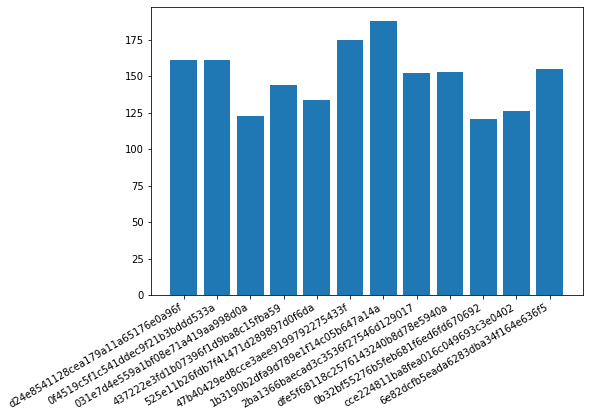

In [30]:
#Solve Question 7 below
order_id, time_passed = map(list, zip(*result))
fig = plt.figure() 
ax = fig.add_axes([0,0,1,1]) 
ax.bar(order_id, time_passed) 
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right') 
plt.show()

## Question 8 (15 pts)

In [31]:
# Write an SQL query to find the total number of orders per week day, e.g., Monday -> 150 orders, Tuesday -> 200 orders,
# Wednesday -> 500 orders, etc. Use the "order_purchase_timestamp" attribute when counting the number of orders.
# Plot the result using a bar chart (days of week on x-axis, number of orders on y-axis). 

# HINT: Check out the "WEEKDAY" function of MySQL. 

(16196, 'Monday')
(15963, 'Tuesday')
(15552, 'Wednesday')
(10887, 'Saturday')
(11960, 'Sunday')
(14761, 'Thursday')
(14122, 'Friday')


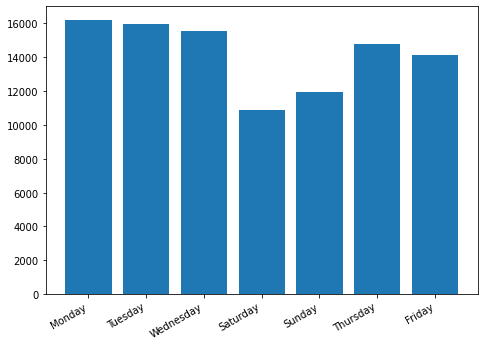

In [32]:
# Solve Question 8 below
db_cursor.execute(
    """
    SELECT Count(*) as count, DAYNAME(order_purchase_timestamp) as days
    FROM ORDERS
    Group by days
    """)

result = db_cursor.fetchall()
for x in result:
    print(x)
    
count, day = map(list, zip(*result))
fig = plt.figure() 
ax = fig.add_axes([0,0,1,1]) 
ax.bar(day,count) 
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right') 
plt.show()

In [33]:
db_cursor.close()
db_connection.close()